In [1]:
#Imports
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt

from sklearn import random_projection
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics


DATA_BASE = "data\\"

In [2]:
#Drop Unnecessary Columns from Output 
def process_outputcsv(fname):
    
    out_csv = pd.read_csv(DATA_BASE + fname)
    cols = ['FEATUREID'] + list(out_csv.columns[1:])
    out_csv.columns = cols
    out_csv.drop('FEATUREID', axis=1, inplace=True)
    
    out_csv.fillna(lambda x: x.mean(), inplace=True)
    out_csv_scaled = preprocessing.scale(out_csv.select_dtypes(include=['int64', 'float']))    
    
    return(out_csv_scaled)


In [3]:
#Drop Unnecessary Columns fro Clinical
def process_clinical(fname, test=False):
    
    clinical_csv = pd.read_csv(DATA_BASE + fname)
    cols = ['STUDYID'] + list(clinical_csv.columns[1:])
    clinical_csv.columns = cols
    
    to_drop = [u'STUDYID', 
               u'SUBJECTID',
               u'EARLYTX', 
               u'SHAM', 
               u'CEL',
               u'SAMPLEID']
    
    clinical_csv.drop(to_drop, axis=1, inplace=True)
    number = preprocessing.LabelEncoder()
    
    clinical_csv['GENDER'] = number.fit_transform(clinical_csv['GENDER'].astype('str'))
    if test:
       col_set = ['AGE', 'GENDER'] 
    else:
       col_set = ['AGE', 'GENDER', 'SHEDDING_SC1', 'SYMPTOMATIC_SC2']
    
    clinical_csv[col_set] = clinical_csv[col_set].fillna(lambda x: x.mode())
    nums_scaled = preprocessing.scale(clinical_csv.select_dtypes(include=['int64', 'float']))
    y = []
    
    if test:
       clinical_csv[u'AGE'] = nums_scaled[:, 0]
       clinical_csv[u'TIMEHOURS'] = nums_scaled[:, 1]
    else:
       clinical_csv[u'AGE'] = nums_scaled[:, 0]
       clinical_csv[u'TIMEHOURS'] = nums_scaled[:, 2]
       
       y = np.ravel(clinical_csv[u'SYMPTOMATIC_SC2'])
       clinical_csv.drop([u'SHEDDING_SC1', u'SYMPTOMATIC_SC2', u'LOGSYMPTSCORE_SC3'], axis=1, inplace=True)
    
    return(clinical_csv, y)

In [4]:
#Reduce Dimensionlity
def features_dim_reduction(X, method='Sparse'):
    
    print ("Applying dimensionality reduction to X of shape:")
    print (X.shape)
    print("Using %s Random Projector" % (method))
    
    if method == 'Sparse':
       txf = random_projection.SparseRandomProjection()       
    elif method == 'Gaussian':
       txf = random_projection.GaussianRandomProjection()
    
    X_reduced = txf.fit_transform(X)
    print ("Resulting reduced X shape of:")
    print (X_reduced.shape)
    
    return(X_reduced)

In [5]:
#Select Features using RndomForestClassifier
def features_selection(X_reduced_train, X_reduced_test, y, num_features=100):
    
    clf = RandomForestClassifier()
    clf.fit(X_reduced_train, y)
    
    importances = clf.feature_importances_
    sorted_idx = np.flipud(np.argsort(importances))
    best_feat_indexes = sorted_idx[:num_features]
    
    X_train = X_reduced_train[:, best_feat_indexes]
    X_test = X_reduced_test[:, best_feat_indexes]
    
    return(X_train, y, X_test)


In [6]:
#Visualize Top 30 Features
def visualize_topn_features(num_features=100, n=20):
    
    fname = 'output.csv'
    
    out_csv = pd.read_csv(DATA_BASE + fname)
    cols = ['FEATUREID'] + list(out_csv.columns[1:])
    out_csv.columns = cols
    out_csv.drop('FEATUREID', axis=1, inplace=True)
    out_csv.fillna(lambda x: x.mean(), inplace=True)
    
    X = out_csv.select_dtypes(include=['int64', 'float'])
    _, y = process_clinical('Training.csv')
    
    clf = RandomForestClassifier()
    clf.fit(X, y)
    
    importances = clf.feature_importances_
    sorted_idx = np.flipud(np.argsort(importances))
    best_feat_indexes = np.flipud(sorted_idx[:num_features])
    
    padding = np.arange(n) + 0.5
    
    plt.barh(padding, importances[best_feat_indexes[:n]], align='center')
    plt.yticks(padding, X.columns[best_feat_indexes[:n]])
    plt.xlabel("Relative Importance")
    plt.title("Variable Importance")
    plt.show()


In [7]:
# Store data in CSV for checking - Not a required step
def store_data_into_csv(data, csvout):
    out = open(csvout, 'w')
    out.write("sep=;\n")
    for row in data:
        for column in row:
            out.write(str(column)+";")
            out.write('\n')


In [8]:
# Prepare Test and Train Data via Dimensionally reduced data 
def prepare_train_test(save=True):
    
    train_csv, y = process_clinical('Training.csv')
    trainout_csv = process_outputcsv('output.csv')
    print train_csv.shape
    print trainout_csv.shape    
    test_csv, _ = process_clinical('Phase2_Clinical.csv', True)
    testout_csv = process_outputcsv('Phas2Exp.csv')
    print test_csv.shape
    print testout_csv.shape
    
    X_raw_train = np.hstack([train_csv, trainout_csv])
    X_raw_test = np.hstack([test_csv, testout_csv])
    
    X_raw = np.vstack([X_raw_train, X_raw_test])
    X_reduced = features_dim_reduction(X_raw)
    
    X_reduced_train = X_reduced[:X_raw_train.shape[0], :]
    X_reduced_test = X_reduced[X_raw_train.shape[0]:, :]
    
    X_train, y, X_test = features_selection(X_reduced_train, X_reduced_test, y)
    
    if save:
       store_data_into_csv(X_train, "x_train_Phase2.csv")
       store_data_into_csv(X_test, "x_test_Phase2.csv")
    
    return(X_train, y, X_test)


In [9]:
# Different Classifiers to Test the Accuracy of Predictions
def models_building():
    
    svm = SVC()
    nb = GaussianNB()
    lr = LogisticRegression()
    dtc = DecisionTreeClassifier(random_state=0)
   
    X_train, y, X_test = prepare_train_test()
    x_train, x_test, y_train, y_test = train_test_split(X_train, y, test_size=0.3, random_state=2017)
    
    print "Models training and evaluation on train set"
    
    svm.fit(x_train, y_train)
    nb.fit(x_train, y_train)
    lr.fit(x_train, y_train)
    dtc.fit(x_train, y_train)
    
    svm_train_pred = svm.predict(x_test)
    nb_train_pred = nb.predict(x_test)
    lr_train_pred = lr.predict(x_test)
    dtc_train_pred = dtc.predict(x_test)
    
    print "SVM Accuracy on Training phase's Test split\n"
    print metrics.accuracy_score(y_test, svm_train_pred)
    print "Naive Bayes Accuracy on Training phase's Test split\n"
    print metrics.accuracy_score(y_test, nb_train_pred)
    print "Logistic Regression Accuracy on Training phase's Test split\n"
    print metrics.accuracy_score(y_test, lr_train_pred)  
    print "Decision Tree Accuracy on Training phase's Test split\n"
    print metrics.accuracy_score(y_test, dtc_train_pred)
    
    svm_test_pred = svm.predict(X_test)
    nb_test_pred = nb.predict(X_test)
    lr_test_pred = lr.predict(X_test)
    dtc_test_pred = dtc.predict(X_test)
    
    print svm_test_pred
    print nb_test_pred
    print lr_test_pred
    print dtc_test_pred

In [10]:
if __name__=='__main__':
   models_building()

(2371, 3)
(2371L, 22277L)
(52, 3)
(52L, 22277L)
Applying dimensionality reduction to X of shape:
(2423L, 22280L)
Using Sparse Random Projector
Resulting reduced X shape of:
(2423L, 6679L)
Models training and evaluation on train set
SVM Accuracy on Training phase's Test split

0.824438202247
Naive Bayes Accuracy on Training phase's Test split

0.671348314607
Logistic Regression Accuracy on Training phase's Test split

0.733146067416
Decision Tree Accuracy on Training phase's Test split

0.606741573034
[1 1 0 1 1 1 0 0 0 0 0 0 0 0 0 1 1 1 1 0 1 1 0 1 1 0 1 1 1 1 0 1 1 1 0 1 1
 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1]
[1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 1 0 0 1 1 0 1 0 1 0 0 1 1 1 0 0 0
 1 1 0 1 1 1 0 1 0 1 1 1 0 1 0]
[1 1 0 1 0 1 0 0 0 0 1 0 0 1 1 1 0 0 1 1 1 1 0 1 0 1 1 0 1 1 0 1 1 0 0 0 1
 1 1 0 1 1 1 0 1 1 1 0 1 1 1 1]
[1 1 1 1 1 1 0 0 0 1 1 0 0 1 0 1 1 0 1 1 1 1 1 1 0 1 1 1 0 0 0 1 1 0 0 1 0
 0 1 0 0 0 1 1 1 1 1 1 1 1 1 0]


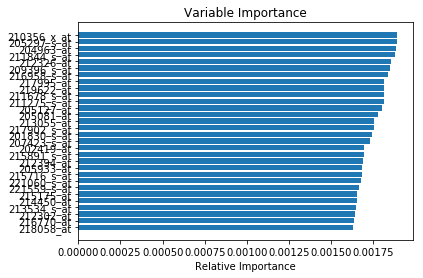

In [11]:
visualize_topn_features(num_features=100, n=30)